In [1]:
import os
import warnings
import platform
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

warnings.filterwarnings("ignore")

In [14]:
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Database
SERVER = ""
DATABASE = ""
QUERY = "SELECT * FROM gold.fact_sales"

In [4]:
def connect_to_database() -> pd.DataFrame:
    """
    Establish connection to SQL Server and fetch sales data.
    Returns DataFrame.
    """
    conn_str = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SERVER};"
        f"DATABASE={DATABASE};"
        f"Trusted_Connection=yes;"
    )
    try:
        conn = pyodbc.connect(conn_str)
        print("Database connection successful!")
        df = pd.read_sql(QUERY, conn)
        print(f"Loaded {len(df):,} records from database")
        return df
    except Exception as e:
        print(f"Database connection failed: {e}")
        raise
    finally:
        if "conn" in locals():
            conn.close()

In [63]:
df_raw = connect_to_database()

Database connection successful!
Loaded 60,398 records from database


In [64]:
df_raw.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price
0,SO43697,20,21768,2010-12-29,2011-01-05,2011-01-10,3578,1,3578
1,SO43698,9,28389,2010-12-29,2011-01-05,2011-01-10,3400,1,3400
2,SO43699,9,25863,2010-12-29,2011-01-05,2011-01-10,3400,1,3400
3,SO43700,41,14501,2010-12-29,2011-01-05,2011-01-10,699,1,699
4,SO43701,9,11003,2010-12-29,2011-01-05,2011-01-10,3400,1,3400


In [65]:
df_raw.shape

(60398, 9)

In [66]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_number   60398 non-null  object
 1   product_key    60398 non-null  int64 
 2   customer_id    60398 non-null  int64 
 3   order_date     60379 non-null  object
 4   shipping_date  60398 non-null  object
 5   due_date       60398 non-null  object
 6   sales          60398 non-null  int64 
 7   quantity       60398 non-null  int64 
 8   price          60398 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 4.1+ MB


In [67]:
df_raw['order_date'] = pd.to_datetime(df_raw['order_date'], errors='coerce')
df_raw['shipping_date'] = pd.to_datetime(df_raw['shipping_date'])
df_raw["due_date"] = pd.to_datetime(df_raw["due_date"])

In [68]:
df_raw[['sales','quantity','price']].describe()

,sales,quantity,price
count,60398.000000,60398.000000,60398.000000
mean,486.046723,1.000414,486.037783
std,928.450537,0.044011,928.454329
min,2.000000,1.000000,2.000000
25%,8.000000,1.000000,8.000000
50%,30.000000,1.000000,30.000000
75%,540.000000,1.000000,540.000000
max,3578.000000,10.000000,3578.000000


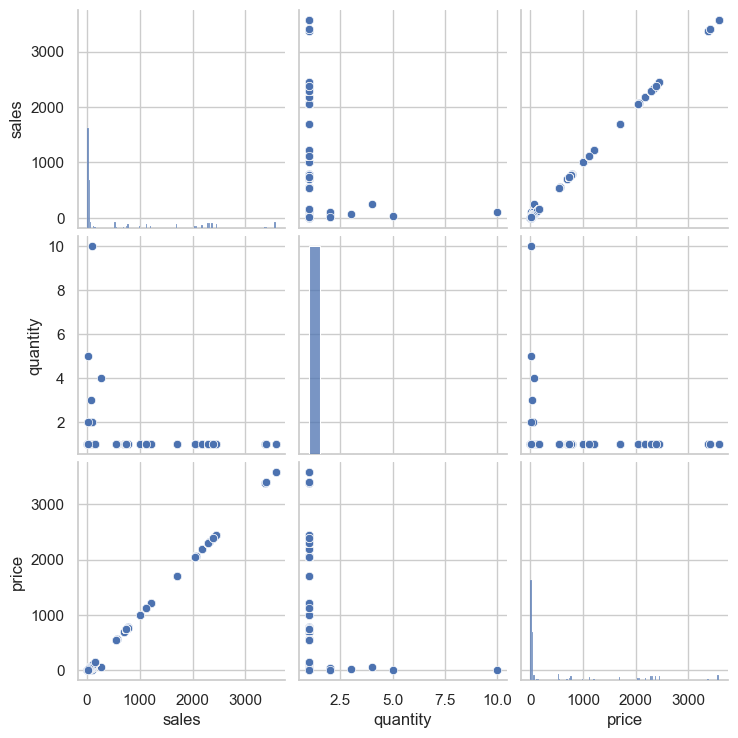

In [69]:
sns.pairplot(df_raw[['sales','quantity','price']])

<Axes: xlabel='sales'>

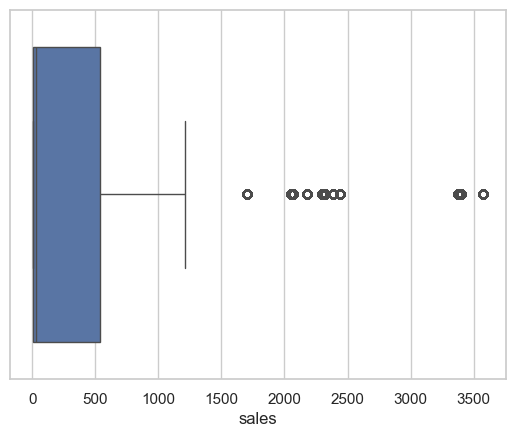

In [83]:
sns.boxplot(x=df_raw['sales'])

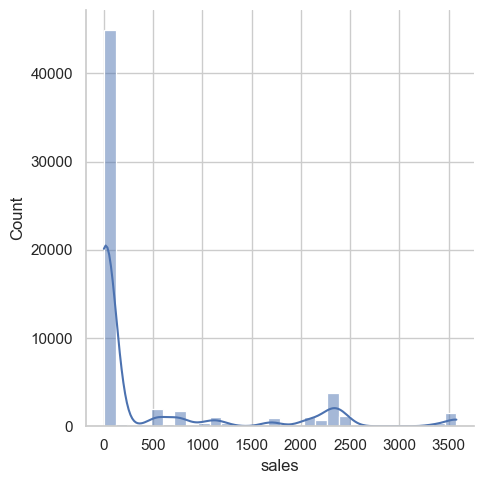

In [71]:
sns.displot(df_raw['sales'], bins=30, kde=True)

In [72]:
df_raw.isna().sum()

order_number      0
product_key       0
customer_id       0
order_date       19
shipping_date     0
due_date          0
sales             0
quantity          0
price             0
dtype: int64

In [73]:
df_raw[df_raw.isna().any(axis=1)]

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price
35319,SO64338,245,22819,NaT,2013-08-23,2013-08-28,35,1,35
35320,SO64339,286,16322,NaT,2013-08-23,2013-08-28,25,1,25
35321,SO64339,290,16322,NaT,2013-08-23,2013-08-28,4,1,4
35322,SO64340,289,21521,NaT,2013-08-23,2013-08-28,5,1,5
35323,SO64340,283,21521,NaT,2013-08-23,2013-08-28,30,1,30
35420,SO64377,125,12373,NaT,2013-08-24,2013-08-29,2320,1,2320
35422,SO64377,235,12373,NaT,2013-08-24,2013-08-29,24,1,24
35427,SO64379,282,13008,NaT,2013-08-24,2013-08-29,25,1,25
35432,SO64381,259,21995,NaT,2013-08-24,2013-08-29,2,1,2
36046,SO64623,285,26791,NaT,2013-08-27,2013-09-01,21,1,21


In [74]:
df_missing = df_raw[df_raw.isna().any(axis=1)]
df_missing.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price
35319,SO64338,245,22819,NaT,2013-08-23,2013-08-28,35,1,35
35320,SO64339,286,16322,NaT,2013-08-23,2013-08-28,25,1,25
35321,SO64339,290,16322,NaT,2013-08-23,2013-08-28,4,1,4
35322,SO64340,289,21521,NaT,2013-08-23,2013-08-28,5,1,5
35323,SO64340,283,21521,NaT,2013-08-23,2013-08-28,30,1,30


In [75]:
df_missing['order_date'].fillna(df_missing['shipping_date'] - pd.Timedelta(days=1), inplace=True)

In [76]:
df_missing.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price
35319,SO64338,245,22819,2013-08-22,2013-08-23,2013-08-28,35,1,35
35320,SO64339,286,16322,2013-08-22,2013-08-23,2013-08-28,25,1,25
35321,SO64339,290,16322,2013-08-22,2013-08-23,2013-08-28,4,1,4
35322,SO64340,289,21521,2013-08-22,2013-08-23,2013-08-28,5,1,5
35323,SO64340,283,21521,2013-08-22,2013-08-23,2013-08-28,30,1,30


In [77]:
df_raw['order_date'].fillna(df_raw['shipping_date'] - pd.Timedelta(days=1), inplace=True)

In [78]:
df_raw.dtypes

order_number             object
product_key               int64
customer_id               int64
order_date       datetime64[ns]
shipping_date    datetime64[ns]
due_date         datetime64[ns]
sales                     int64
quantity                  int64
price                     int64
dtype: object

In [79]:
df_raw.isna().sum()

order_number     0
product_key      0
customer_id      0
order_date       0
shipping_date    0
due_date         0
sales            0
quantity         0
price            0
dtype: int64

In [85]:
df_raw.sales.describe()

count    60398.000000
mean       486.046723
std        928.450537
min          2.000000
25%          8.000000
50%         30.000000
75%        540.000000
max       3578.000000
Name: sales, dtype: float64

In [92]:
df_raw[df_raw['sales']<=1500].shape

(50812, 9)

In [98]:
new_data = df_raw[df_raw['sales']<=1500]
new_data.reset_index(drop=True, inplace=True)
new_data.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price
0,SO43700,41,14501,2010-12-29,2011-01-05,2011-01-10,699,1,699
1,SO43708,44,20042,2010-12-31,2011-01-07,2011-01-12,699,1,699
2,SO43717,41,25249,2011-01-02,2011-01-09,2011-01-14,699,1,699
3,SO43723,39,14520,2011-01-04,2011-01-11,2011-01-16,699,1,699
4,SO43726,39,14560,2011-01-05,2011-01-12,2011-01-17,699,1,699


In [99]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50812 entries, 0 to 50811
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_number   50812 non-null  object        
 1   product_key    50812 non-null  int64         
 2   customer_id    50812 non-null  int64         
 3   order_date     50812 non-null  datetime64[ns]
 4   shipping_date  50812 non-null  datetime64[ns]
 5   due_date       50812 non-null  datetime64[ns]
 6   sales          50812 non-null  int64         
 7   quantity       50812 non-null  int64         
 8   price          50812 non-null  int64         
dtypes: datetime64[ns](3), int64(5), object(1)
memory usage: 3.5+ MB


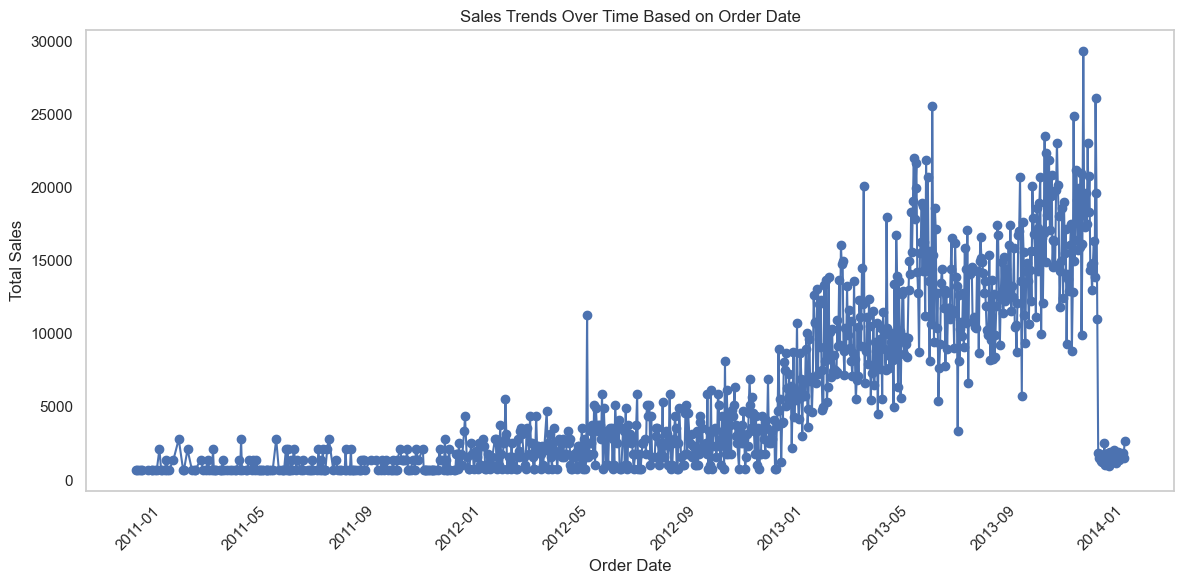

In [ ]:
# Analysis Step 1: Aggregate sales data by order date
sales_trends = new_data.groupby('order_date')['sales'].sum().reset_index()

# Analysis Step 2: Plot sales trends over time
plt.figure(figsize=(12, 6))
plt.plot(sales_trends['order_date'], sales_trends['sales'], marker='o')
plt.title('Sales Trends Over Time Based on Order Date')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""
Time Frame: Data spans from early 2011 to early 2014.
Sales Growth:
There is a clear upward trend in sales over time, particularly noticeable from mid-2012 onwards, indicating consistent growth.
The data shows considerable fluctuations, with several peaks and troughs, reflecting variability in sales activity.
The highest sales point appears to be around January 2014, with figures exceeding 25,000, suggesting a strong month or promotion.
Data Density: A dense cluster of points in the later months indicates increased sales frequency and volume.
"""

<Figure size 1200x600 with 0 Axes>

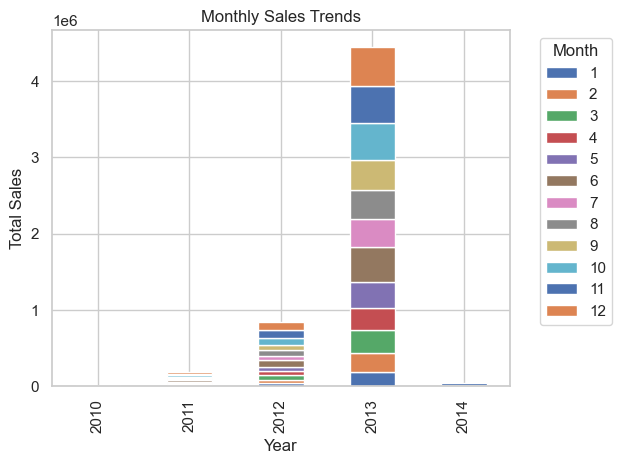

In [ ]:
# Analysis Step 3: Identify seasonal patterns
# Extract month and year for further analysis
new_data['order_month'] = new_data['order_date'].dt.month
new_data['order_year'] = new_data['order_date'].dt.year

# Aggregate sales by month and year
monthly_sales = new_data.groupby(['order_year', 'order_month'])['sales'].sum().unstack()

# Plot monthly sales trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', stacked=True)
plt.title('Monthly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""
Time Period: Covers the years 2010 to 2014.
Sales Distribution:
2013 shows a significant spike in sales, with totals reaching around 4 million, indicating a peak year for sales.
Sales in 2010, 2011, and 2012 are relatively low, with minimal activity observed.
The year 2014 appears to start strong but shows no substantial sales compared to 2013.
Seasonality: The different colors represent monthly sales, suggesting varying sales performance across months, especially noticeable in 2013.
"""

In [104]:
# Calculate lead time
new_data['lead_time'] = (new_data['shipping_date'] - new_data['order_date']).dt.days
new_data.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price,order_month,order_year,lead_time
0,SO43700,41,14501,2010-12-29,2011-01-05,2011-01-10,699,1,699,12,2010,7
1,SO43708,44,20042,2010-12-31,2011-01-07,2011-01-12,699,1,699,12,2010,7
2,SO43717,41,25249,2011-01-02,2011-01-09,2011-01-14,699,1,699,1,2011,7
3,SO43723,39,14520,2011-01-04,2011-01-11,2011-01-16,699,1,699,1,2011,7
4,SO43726,39,14560,2011-01-05,2011-01-12,2011-01-17,699,1,699,1,2011,7


In [106]:
new_data[['order_date', 'shipping_date', 'lead_time']]

,order_date,shipping_date,lead_time
0,2010-12-29,2011-01-05,7
1,2010-12-31,2011-01-07,7
2,2011-01-02,2011-01-09,7
3,2011-01-04,2011-01-11,7
4,2011-01-05,2011-01-12,7
...,...,...,...
50807,2014-01-28,2014-02-04,7
50808,2014-01-28,2014-02-04,7
50809,2014-01-28,2014-02-04,7
50810,2014-01-28,2014-02-04,7


In [110]:
new_data['lead_time'].unique()

array([7, 1], dtype=int64)

In [113]:
# Average lead time
average_lead_time = new_data['lead_time'].mean()
print(f"Average Lead Time: {int(round(average_lead_time,0))} days")

Average Lead Time: 7 days


In [114]:
# Analyze shipping delays
new_data['shipping_delay'] = new_data['lead_time'] = 7  # Define your threshold

In [115]:
new_data.head()

,order_number,product_key,customer_id,order_date,shipping_date,due_date,sales,quantity,price,order_month,order_year,lead_time,shipping_delay
0,SO43700,41,14501,2010-12-29,2011-01-05,2011-01-10,699,1,699,12,2010,7,7
1,SO43708,44,20042,2010-12-31,2011-01-07,2011-01-12,699,1,699,12,2010,7,7
2,SO43717,41,25249,2011-01-02,2011-01-09,2011-01-14,699,1,699,1,2011,7,7
3,SO43723,39,14520,2011-01-04,2011-01-11,2011-01-16,699,1,699,1,2011,7,7
4,SO43726,39,14560,2011-01-05,2011-01-12,2011-01-17,699,1,699,1,2011,7,7


In [116]:
monthly_delays = new_data.groupby(new_data['shipping_date'].dt.to_period('M')).agg({'shipping_delay': 'sum'})

Text(0.5, 1.0, 'Monthly Shipping Delays')

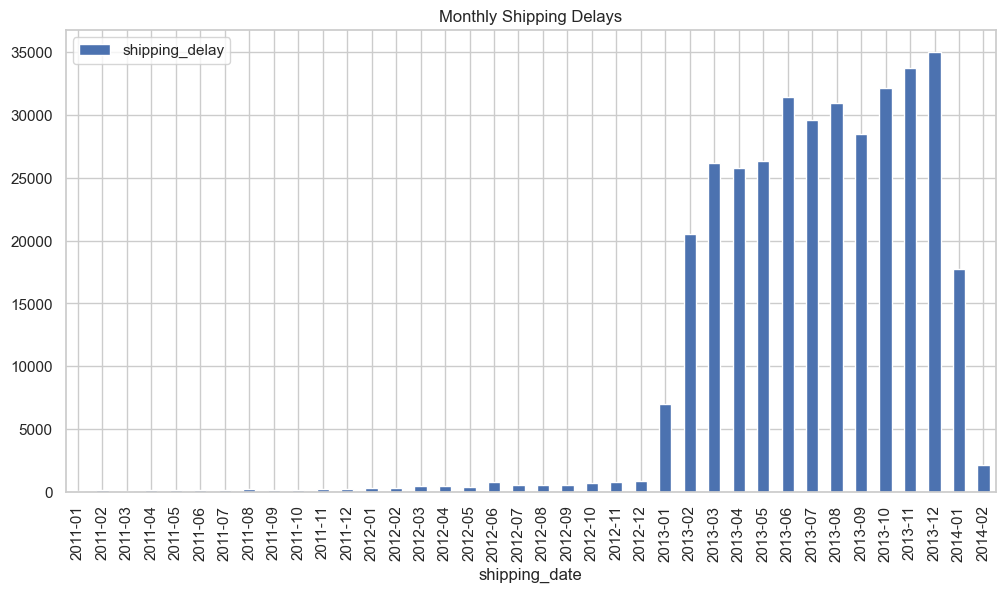

In [118]:
monthly_delays.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Shipping Delays')

In [120]:
# Cash flow analysis
cash_flow_analysis = new_data.groupby(new_data['due_date'].dt.to_period('M')).agg({'sales': 'sum', 'due_date': 'count'})

In [ ]:
sns

,sales,due_date
due_date,,
2011-01,5592,8
2011-02,12582,18
2011-03,8388,12
2011-04,13281,19
2011-05,15378,22


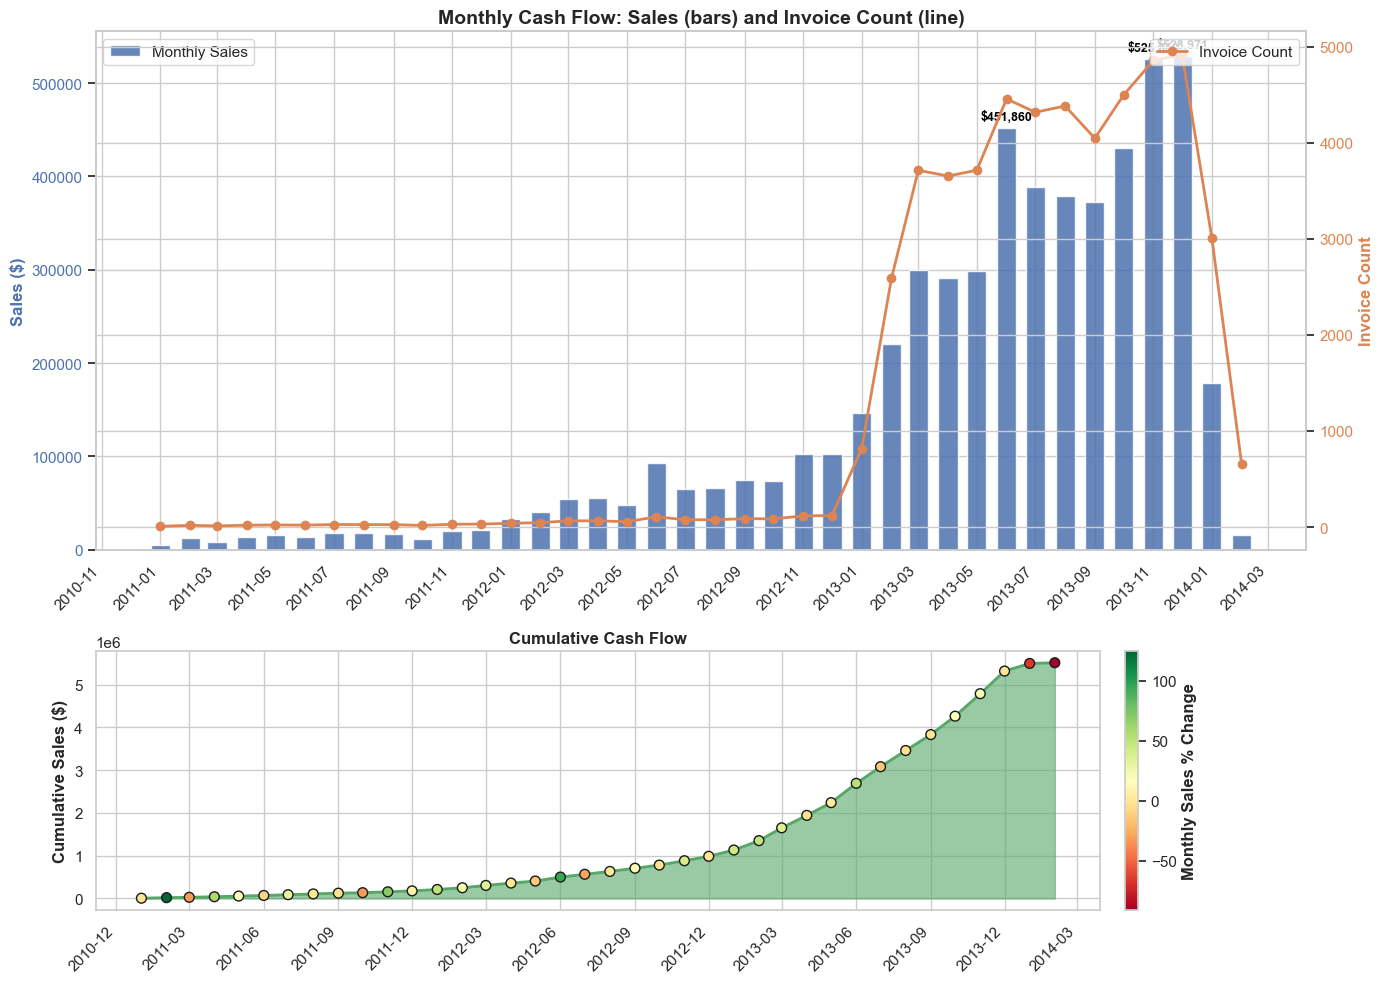

In [ ]:
import matplotlib.dates as mdates

# recompute / ensure structure
cash_flow_analysis = (
    new_data
    .groupby(new_data["due_date"].dt.to_period("M"))
    .agg(sales=("sales", "sum"), invoices=("due_date", "count"))
    .sort_index()
)
# convert PeriodIndex to Timestamp for plotting
cash_flow_analysis.index = cash_flow_analysis.index.to_timestamp()
cash_flow_analysis["pct_change"] = cash_flow_analysis["sales"].pct_change() * 100
cash_flow_analysis["cumulative_sales"] = cash_flow_analysis["sales"].cumsum()

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={"height_ratios": [2, 1]})

# Top: monthly sales (bar) + invoices (line on secondary y)
ax = ax_top
bars = ax.bar(cash_flow_analysis.index, cash_flow_analysis["sales"], width=20, color="C0", alpha=0.85, label="Monthly Sales")
ax.set_ylabel("Sales ($)", color="C0", fontweight="bold")
ax.tick_params(axis="y", labelcolor="C0")

ax2 = ax.twinx()
ax2.plot(cash_flow_analysis.index, cash_flow_analysis["invoices"], color="C1", marker="o", linewidth=2, label="Invoice Count")
ax2.set_ylabel("Invoice Count", color="C1", fontweight="bold")
ax2.tick_params(axis="y", labelcolor="C1")

# Format x-axis for months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

ax.set_title("Monthly Cash Flow: Sales (bars) and Invoice Count (line)", fontsize=14, fontweight="bold")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

# Annotate top 3 months by sales
top3 = cash_flow_analysis["sales"].nlargest(3)
for dt, val in top3.items():
    ax.annotate(f"${val:,.0f}", xy=(dt, val), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=9, fontweight="bold", color="black")

# Bottom: cumulative sales and pct change heatbar
ax = ax_bottom
ax.fill_between(cash_flow_analysis.index, cash_flow_analysis["cumulative_sales"], color="C2", alpha=0.6)
ax.plot(cash_flow_analysis.index, cash_flow_analysis["cumulative_sales"], color="C2", linewidth=2)
ax.set_ylabel("Cumulative Sales ($)", fontweight="bold")
ax.set_title("Cumulative Cash Flow", fontsize=12, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

# Optional: show pct change as colored markers
pc = cash_flow_analysis["pct_change"].fillna(0)
sc = ax.scatter(cash_flow_analysis.index, cash_flow_analysis["cumulative_sales"], c=pc, cmap="RdYlGn", edgecolor="k", zorder=3, s=50)
cbar = fig.colorbar(sc, ax=ax_bottom, orientation="vertical", pad=0.02)
cbar.set_label("Monthly Sales % Change", fontweight="bold")

plt.tight_layout()
plt.show()

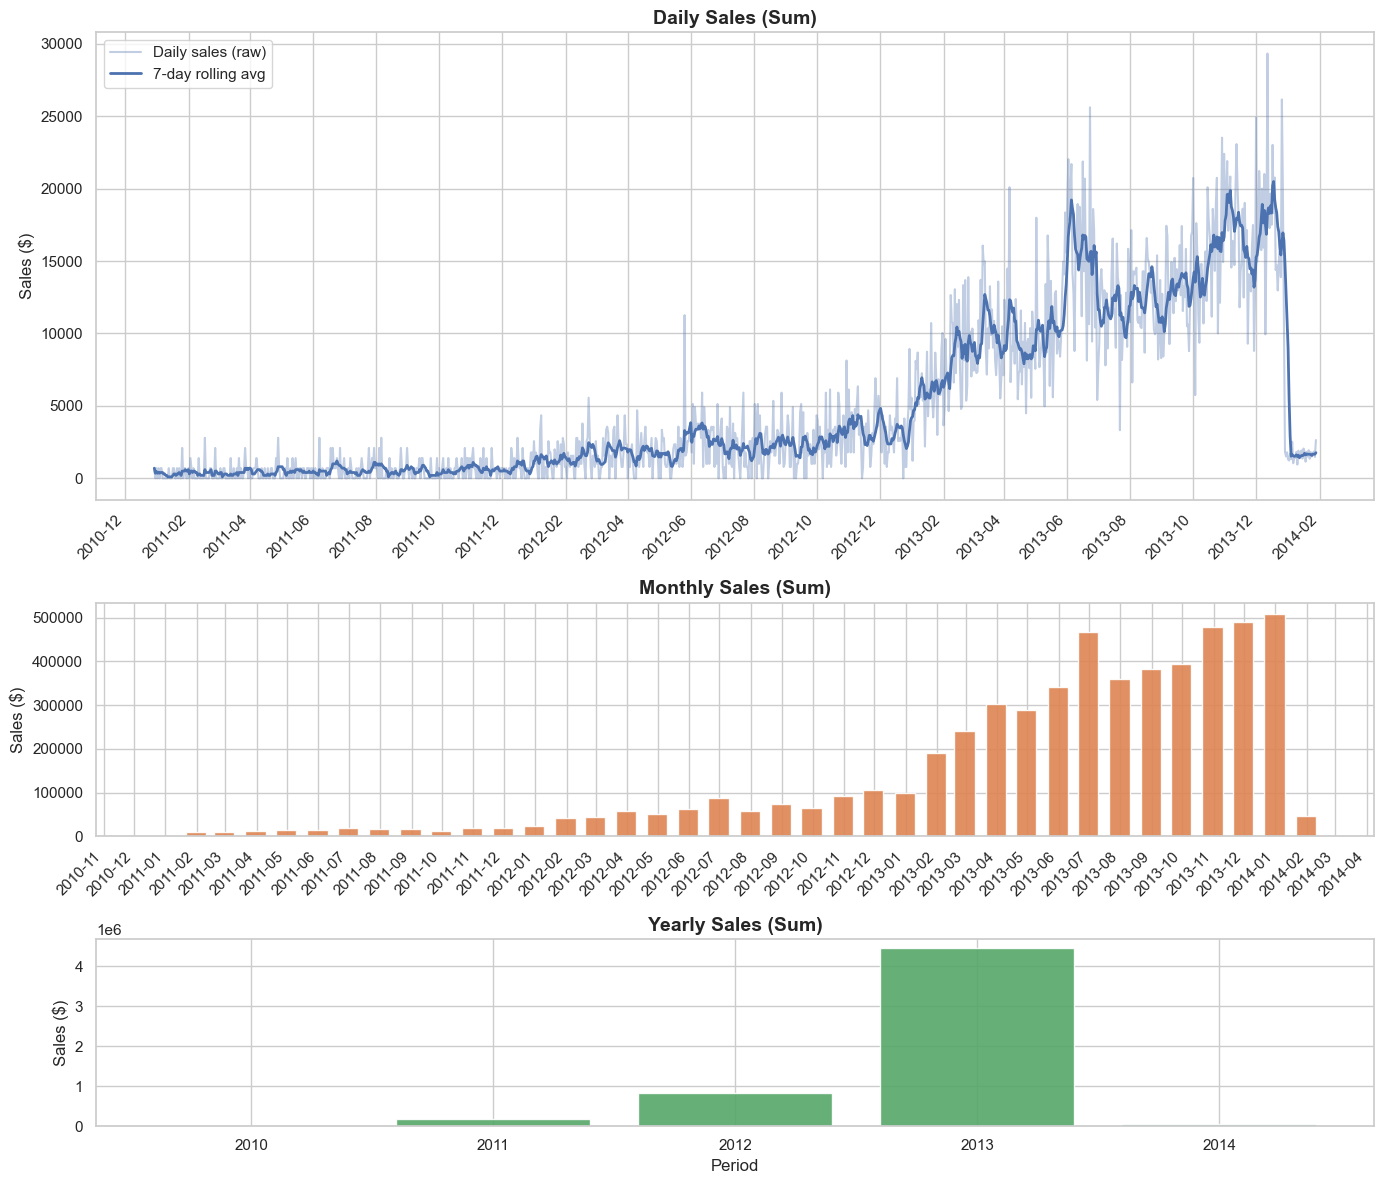

In [130]:
# Set index once to resample efficiently
nd = new_data.set_index('order_date')

# Aggregate
daily = nd['sales'].resample('D').sum()
monthly = nd['sales'].resample('M').sum()
yearly = nd['sales'].resample('Y').sum()

# Smooth daily for better visibility (7-day rolling)
daily_sm = daily.rolling(7, min_periods=1).mean()

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False, gridspec_kw={'height_ratios': [2, 1, 0.8]})

# Daily (line + rolling)
ax = axes[0]
ax.plot(daily.index, daily, label='Daily sales (raw)', color='C0', alpha=0.35)
ax.plot(daily_sm.index, daily_sm, label='7-day rolling avg', color='C0', linewidth=2)
ax.set_title('Daily Sales (Sum)', fontsize=14, fontweight='bold')
ax.set_ylabel('Sales ($)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()

# Monthly (bar)
ax = axes[1]
ax.bar(monthly.index, monthly.values, width=20, color='C1', alpha=0.9)  # Removed to_timestamp()
ax.set_title('Monthly Sales (Sum)', fontsize=14, fontweight='bold')
ax.set_ylabel('Sales ($)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Yearly (bar)
ax = axes[2]
ax.bar(yearly.index.year.astype(str), yearly.values, color='C2', alpha=0.9)  # No need for to_timestamp()
ax.set_title('Yearly Sales (Sum)', fontsize=14, fontweight='bold')
ax.set_ylabel('Sales ($)')
ax.set_xlabel('Period')

plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [131]:
new_data.shape

(50812, 14)

In [132]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50812 entries, 0 to 50811
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_number     50812 non-null  object        
 1   product_key      50812 non-null  int64         
 2   customer_id      50812 non-null  int64         
 3   order_date       50812 non-null  datetime64[ns]
 4   shipping_date    50812 non-null  datetime64[ns]
 5   due_date         50812 non-null  datetime64[ns]
 6   sales            50812 non-null  int64         
 7   quantity         50812 non-null  int64         
 8   price            50812 non-null  int64         
 9   order_month      50812 non-null  int64         
 10  order_year       50812 non-null  int64         
 11  lead_time        50812 non-null  int64         
 12  shipping_delay   50812 non-null  int64         
 13  shipped_on_time  50812 non-null  bool          
dtypes: bool(1), datetime64[ns](3), int64(9

In [147]:
data = new_data.copy()

In [148]:
data.set_index('order_date', inplace=True)

# Aggregate sales by day
daily_sales = data.resample('D').sum()['sales'].reset_index()
daily_sales.columns = ['order_date', 'sales']

In [149]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

In [150]:
import numpy as np

# Normalize the sales data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['sales'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['sales'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # Example time step
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [151]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0278
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 16/50
28/28 ━

In [159]:
data.to_csv("final.csv", index=False)

In [ ]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")

# Set the experiment name
mlflow.set_experiment("LSTM_Sales_Prediction")

2025/10/30 23:29:43 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Sales_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/413810950051950195', creation_time=1761863383852, experiment_id='413810950051950195', last_update_time=1761863383852, lifecycle_stage='active', name='LSTM_Sales_Prediction', tags={}>

In [157]:
def prepare_data(data, time_step):
    # Normalize and create sequences
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['sales'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])
    return np.array(X), np.array(y), scaler

def build_and_train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    return model

In [160]:
# Start MLflow run
with mlflow.start_run() as run:
    # Prepare data
    time_step = 10
    X, y, scaler = prepare_data(train, time_step)

    # Reshape data for LSTM
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Train the model
    model = build_and_train_model(X, y)

    # Predict and calculate metrics
    X_test, y_test, _ = prepare_data(test, time_step)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(mean_squared_error(test['sales'].values[time_step+1:], predictions))
    
    # Log parameters and metrics
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 32)
    mlflow.log_metric("rmse", rmse)
    
    # Log the model
    mlflow.keras.log_model(model, "lstm_model")

    # Log the training data used
    mlflow.log_artifact("final.csv")  # Replace with your actual data file path

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0207
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0083
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078
Epoch 16/50
28

2025/10/30 23:33:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/30 23:33:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/30 23:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dapper-flea-152 at: http://localhost:5000/#/experiments/413810950051950195/runs/87fac5dac76844ca8fe4282748cd53b2
🧪 View experiment at: http://localhost:5000/#/experiments/413810950051950195
